In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from utils import get_runtime_stats

In [2]:
result_dir = Path("results")

performance_metric_file = result_dir / "benchmark.tsv"
performance_metric_threading_file = result_dir / "benchmark_threading.tsv"
performance_metric_gene_sig_file = (
    result_dir / "benchmark_sainsc_genes_vs_signatures.tsv"
)
performance_metric_area_frac_file = result_dir / "benchmark_sainsc_area_vs_fraction.tsv"

sainsc_gene_sig_job_file = Path("benchmark") / "sainsc_benchmark_genes_sigs.tsv"
sainsc_area_fraction_job_file = Path("benchmark") / "sainsc_benchmark_area_fraction.tsv"

In [3]:
result_dir.mkdir(parents=True, exist_ok=True)

# FICTURE / TopACT comparison

In [4]:
job_ids = {
    3793787: "FICTURE (1 thread)",
    3789271: "FICTURE (8 threads)",
    3789462: "sainsc (8k genes)",
    3788941: "sainsc (20k genes)",
    3791297: "TopACT",
}

stats_comparison = get_runtime_stats(job_ids)

In [5]:
stats_comparison.to_csv(performance_metric_file, sep="\t", index=False)

# Threading comparison

In [6]:
job_ids = {
    3789271: "FICTURE_8",
    3789272: "FICTURE_16",
    3789273: "FICTURE_32",
    3789274: "FICTURE_96",
    3788941: "sainsc_8",
    3788942: "sainsc_16",
    3788943: "sainsc_32",
    3788944: "sainsc_96",
    3788945: "Sainsc.jl_8",
    3788946: "Sainsc.jl_16",
    3788947: "Sainsc.jl_32",
    3788948: "Sainsc.jl_96",
}

stats_threading = get_runtime_stats(job_ids)

stats_threading[["tool", "# threads"]] = stats_threading["tool"].str.split(
    "_", n=1, expand=True
)
stats_threading = stats_threading.assign(threads=lambda df: df["# threads"].astype(int))

In [7]:
stats_threading.to_csv(performance_metric_threading_file, sep="\t", index=False)

# #Signatures + #Genes

In [8]:
job_ids = pd.read_table(sainsc_gene_sig_job_file, index_col=0).assign(
    pseudo=lambda df: df["n_genes"].astype(str) + "_" + df["n_signatures"].astype(str)
)

stats_sainsc_gene_sig = get_runtime_stats(job_ids["pseudo"].to_dict())
stats_sainsc_gene_sig = stats_sainsc_gene_sig.join(job_ids).drop(
    columns=["pseudo", "tool"]
)

In [9]:
stats_sainsc_gene_sig.to_csv(performance_metric_gene_sig_file, sep="\t", index=False)

# Area + Fraction

In [10]:
job_ids = pd.read_table(sainsc_area_fraction_job_file, index_col=0).assign(
    pseudo=lambda df: df["area"].astype(str)
    + "_"
    + df["fraction_transcripts"].astype(str)
)

stats_sainsc_area_frac = get_runtime_stats(job_ids["pseudo"].to_dict())
stats_sainsc_area_frac = stats_sainsc_area_frac.join(job_ids).drop(
    columns=["pseudo", "tool"]
)

In [11]:
stats_sainsc_area_frac.to_csv(performance_metric_area_frac_file, sep="\t", index=False)

# MERFISH

In [12]:
get_runtime_stats({3791196: "MERFISH_Sainsc"})

,CPU time [s],wall time [s],max memory [MB],tool
JobID,,,,
3791196,11307.0,1530,7538.62,MERFISH_Sainsc


# Plotting

In [13]:
stats_comparison = pd.read_table(performance_metric_file)
stats_sainsc_gene_sig = pd.read_table(performance_metric_gene_sig_file)
stats_sainsc_area_frac = pd.read_table(performance_metric_area_frac_file)
stats_threading = pd.read_table(performance_metric_threading_file)

In [14]:
stats_comparison = stats_comparison.assign(
    **{
        "Max memory [GB]": lambda x: x["max memory [MB]"] / 1e3,
        "Wall time [h]": lambda x: x["wall time [s]"] / 60**2,
        "CPU time [h]": lambda x: x["CPU time [s]"] / 60**2,
    }
).rename(columns={"tool": "Tool"})

stats_comparison

,CPU time [s],wall time [s],max memory [MB],Tool,Max memory [GB],Wall time [h],CPU time [h]
0,54634.0,6998,5818.30,sainsc (20k genes),5.81830,1.943889,15.176111
1,26592.0,9216,8925.64,FICTURE (8 threads),8.92564,2.560000,7.386667
2,21780.0,2787,5489.15,sainsc (8k genes),5.48915,0.774167,6.050000
3,4879158.0,604817,82934.93,TopACT,82.93493,168.004722,1355.321667
4,22715.0,18628,6419.38,FICTURE (1 thread),6.41938,5.174444,6.309722


In [15]:
stats_sainsc_gene_sig = stats_sainsc_gene_sig.assign(
    **{
        "Max memory [GB]": lambda x: x["max memory [MB]"] / 1e3,
        "Wall time [min]": lambda x: x["wall time [s]"] / 60,
        "CPU time [min]": lambda x: x["CPU time [s]"] / 60,
    }
).rename(columns={"n_signatures": "# signatures", "n_genes": "# genes"})

In [16]:
stats_sainsc_area_frac = stats_sainsc_area_frac.assign(
    **{
        "Max memory [GB]": lambda x: x["max memory [MB]"] / 1e3,
        "Wall time [min]": lambda x: x["wall time [s]"] / 60,
        "CPU time [min]": lambda x: x["CPU time [s]"] / 60,
    }
).rename(columns={"area": "Sample area [%]", "fraction_transcripts": "Transcripts [%]"})

In [17]:
stats_threading = (
    stats_threading.assign(
        **{
            "Max memory [GB]": lambda x: x["max memory [MB]"] / 1e3,
            "Wall time [min]": lambda x: x["wall time [s]"] / 60,
            "CPU time [h]": lambda x: x["CPU time [s]"] / 60**2,
        }
    )
    .rename(columns={"tool": "Tool"})
    .loc[lambda df: df["threads"] < 50]
)

In [18]:
order = [
    "sainsc (8k genes)",
    "sainsc (20k genes)",
    "FICTURE (1 thread)",
    "FICTURE (8 threads)",
    "TopACT",
]

palette = sns.color_palette("tab10", len(order))
palette[-1] = "grey"

palette = dict(zip(order, palette))

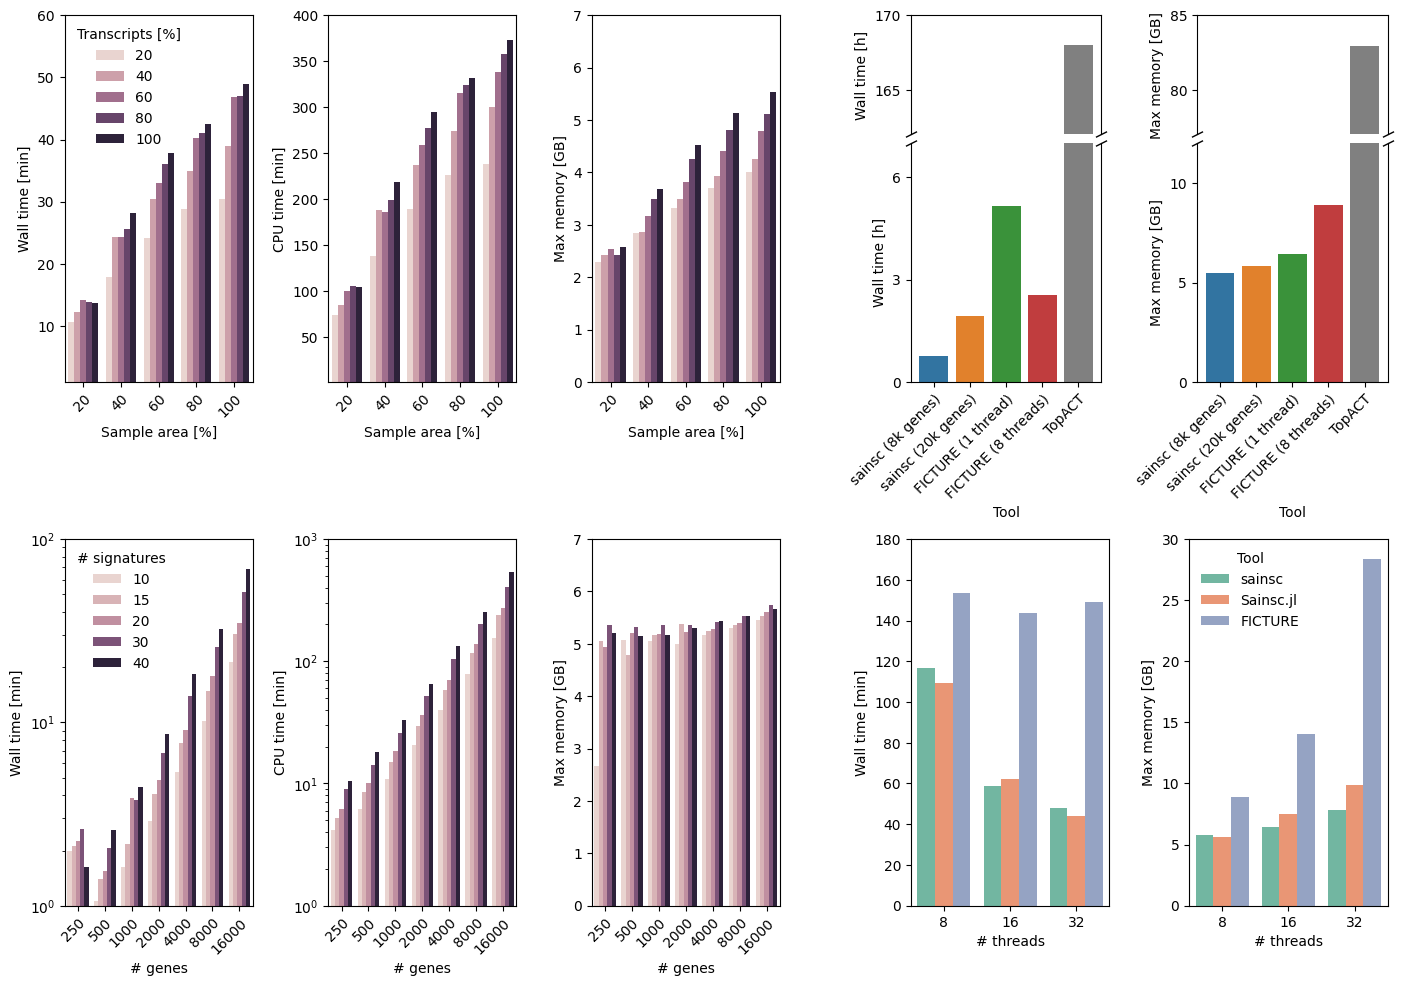

In [19]:
fig = plt.figure(figsize=(15, 10))

subfigures = fig.subfigures(2, 2, width_ratios=[3, 2], hspace=0.1, wspace=-0.05)

## Sainsc benchmark

# Area/beads
axs = subfigures[0, 0].subplots(1, 3)
subfigures[0, 0].subplots_adjust(wspace=0.4)

for i, metric in enumerate(["Wall time [min]", "CPU time [min]", "Max memory [GB]"]):
    legend = i == 0
    sns.barplot(
        data=stats_sainsc_area_frac,
        x="Sample area [%]",
        y=metric,
        hue="Transcripts [%]",
        legend=legend,
        ax=axs[i],
    )
    axs[i].set_xticks(axs[i].get_xticks())
    axs[i].set_xticklabels(
        axs[i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor"
    )
    if legend:
        axs[i].get_legend().set(frame_on=False)

axs[0].set(ylim=(1, 60))
axs[1].set(ylim=(1, 400))
axs[2].set(ylim=(0, 7))

# Genes/Signatures
axs = subfigures[1, 0].subplots(1, 3)
subfigures[1, 0].subplots_adjust(wspace=0.4)

for i, metric in enumerate(["Wall time [min]", "CPU time [min]", "Max memory [GB]"]):
    legend = i == 0
    sns.barplot(
        data=stats_sainsc_gene_sig,
        x="# genes",
        y=metric,
        hue="# signatures",
        legend=legend,
        ax=axs[i],
    )
    axs[i].set_xticks(axs[i].get_xticks())
    axs[i].set_xticklabels(
        axs[i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor"
    )
    if legend:
        axs[i].get_legend().set(frame_on=False)

axs[0].set(ylim=(1, 100), yscale="log")
axs[1].set(ylim=(1, 1_000), yscale="log")
axs[2].set(ylim=(0, 7))


## Comparison

axs = subfigures[0, 1].subplots(2, 2, sharex=True, height_ratios=[1, 2])
subfigures[0, 1].subplots_adjust(hspace=0.05, wspace=0.5)

kwargs_bar = dict(
    x="Tool",
    hue="Tool",
    order=order,
    palette=palette,
)

# Wall time
sns.barplot(
    data=stats_comparison, y="Wall time [h]", ax=axs[1, 0], **kwargs_bar
).set_ylim(0, 7)

sns.barplot(
    data=stats_comparison, y="Wall time [h]", ax=axs[0, 0], **kwargs_bar
).set_ylim(162, 170)

# hide the spines between ax and ax2
axs[1, 0].spines.top.set_visible(False)
axs[0, 0].spines.bottom.set_visible(False)
axs[0, 0].tick_params(axis="x", which="both", bottom=False)

d = 0.5  # proportion of vertical to horizontal extent of the slanted line
kwargs_splitAx = dict(
    marker=[(-1, -d), (1, d)],
    markersize=8,
    linestyle="none",
    color="k",
    mec="k",
    mew=1,
    clip_on=False,
)
axs[0, 0].plot([0, 1], [0, 0], transform=axs[0, 0].transAxes, **kwargs_splitAx)
axs[1, 0].plot([0, 1], [1, 1], transform=axs[1, 0].transAxes, **kwargs_splitAx)

axs[1, 0].set_yticks([0, 3, 6])
axs[0, 0].set_yticks([165, 170])

# Memory
sns.barplot(
    data=stats_comparison, y="Max memory [GB]", ax=axs[1, 1], **kwargs_bar
).set_ylim(0, 12)

sns.barplot(
    data=stats_comparison, y="Max memory [GB]", ax=axs[0, 1], **kwargs_bar
).set_ylim(77, 85)

# hide the spines between ax and ax2
axs[1, 1].spines.top.set_visible(False)
axs[0, 1].spines.bottom.set_visible(False)
axs[0, 1].tick_params(axis="x", which="both", bottom=False)

axs[0, 1].plot([0, 1], [0, 0], transform=axs[0, 1].transAxes, **kwargs_splitAx)
axs[1, 1].plot([0, 1], [1, 1], transform=axs[1, 1].transAxes, **kwargs_splitAx)

axs[1, 1].set_yticks([0, 5, 10])
axs[0, 1].set_yticks([80, 85])

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i, j].set_xticks(axs[i, j].get_xticks())
        axs[i, j].set_xticklabels(
            order, rotation=45, ha="right", rotation_mode="anchor"
        )

## Threading
axs = subfigures[1, 1].subplots(1, 2)
subfigures[1, 1].subplots_adjust(wspace=0.4)
kwargs = {
    "x": "# threads",
    "hue": "Tool",
    "hue_order": ["sainsc", "Sainsc.jl", "FICTURE"],
    "palette": "Set2",
}

_ = sns.barplot(
    data=stats_threading, y="Wall time [min]", ax=axs[0], legend=False, **kwargs
).set(ylim=(0, 180))

_ = sns.barplot(data=stats_threading, y="Max memory [GB]", ax=axs[1], **kwargs).set(
    ylim=(0, 30)
)
_ = axs[1].get_legend().set(frame_on=False)

In [20]:
fig.savefig("figures/Fig_runtime.pdf", dpi=600, bbox_inches="tight")